# Step-by-step verification

In [1]:
import sys
import numpy as np
import numpy.linalg as la
import scipy
sys.path.append('../')

### Load a grayscale image

We start by reading a grayscale image using `openCV`.

In /home/casinglo/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/casinglo/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/casinglo/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/casinglo/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/casinglo/.local/lib/python3.6/site-packages/matplotlib/

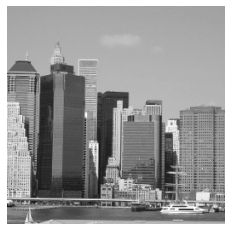

In [2]:
import cv2
import matplotlib.pyplot as plt
im = cv2.imread('city.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(im, cmap='gray')
plt.axis('off')
print('Image size: ', im.shape)

### Generating undersampling mask in *k*-space

We generate a Bernouilli undersampling mask using the `generateSamplingMask()` function with an undersampling ratio `delta`.

Effective undersampling:  0.7492523193359375


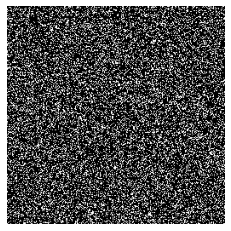

In [3]:
from CSRecoverySuite import generateSamplingMask

# Select an undesampling ratio
delta = 0.25
# Generate an undersampling mask
omega = generateSamplingMask(im.shape, delta, 'bernoulli')
# Verify the undersampling ratio
nsamp = np.sum((omega == 1).ravel())/np.prod(omega.shape)
print('Effective undersampling: ', nsamp)
# Plot mask
plt.imshow(omega[0], cmap='binary')
plt.axis('off')
plt.show()

Other choices to generate the mask are:

- **bernoulli**, each pixel in the mask is generate according to a Bernoulli random variable with probability *delta*.
- **vardentri**, variable density triangular.
- **vardengauss**
- **vardenexp**
- **halton**

### Sparsity in the wavelet domain

We use `pywavelets` and set the wavelet to `haar` and the padding to `zero`

In [4]:
waveName = 'haar'
waveMode = 'zero'

and compute the 2D Haar wavelet transform using

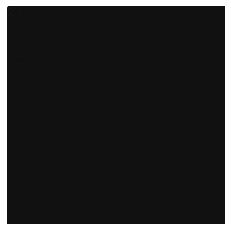

In [5]:
import pywt
wim = pywt.coeffs_to_array(pywt.wavedec2(im, wavelet=waveName, mode=waveMode))[0]
plt.imshow(wim, cmap='gray')
plt.axis('off')
plt.show()

### Constructing the wavelet-Fourier operator

We now define the operator that maps the wavelet coefficients of an image to the undersampled Fourier coefficients of the image.

In [6]:
from maps import OperatorWaveletToFourier

# Assemble operator
A = OperatorWaveletToFourier(im.shape, samplingSet=omega[0], waveletName=waveName)
# Undersampled measurements
yim = A.eval(wim, 1)

print('Input shape: ', A.inShape)
print('Output shape: ', A.outShape)
print('Matrix shape: ', A.shape)

Input shape:  (256, 256)
Output shape:  (49103,)
Matrix shape:  (49103, 65536)


### Reconstruction from noiseless data

We now define the operator that maps the wavelet coefficients of an image to the undersampled Fourier coefficients of the image. **Warning:** This step can take about 4min.

[RECOVERY: L1-NOISY]
 Method:          SoS-L1Ball
 Bound:           1.0000E-02
 Initial values:
     t           [0.0000E+00,   9.8023E+05]
     f(t)        [+3.9067E+04, -9.6628E-03]
 01 | t* = 0.0000E+00 in [0.0000E+00, 9.8023E+05] | f: [+3.9067E+04, -9.6628E-03]
 02 | t* = 9.8023E+05 in [0.0000E+00, 9.8023E+05] | f: [+3.9067E+04, -9.6628E-03]
 03 | t* = 9.8023E+05 in [0.0000E+00, 9.8023E+05] | f: [+3.9067E+04, -9.8289E-03]
 04 | t* = 7.3517E+05 in [0.0000E+00, 9.8023E+05] | f: [+3.9067E+04, -9.8289E-03]
 05 | t* = 9.8020E+05 in [0.0000E+00, 7.3517E+05] | f: [+3.9067E+04, +1.3603E+02]
 06 | t* = 9.1878E+05 in [7.3517E+05, 9.8020E+05] | f: [+1.3603E+02, -9.8624E-03]
 07 | t* = 9.1875E+05 in [7.3517E+05, 9.1878E+05] | f: [+1.3603E+02, -9.8471E-03]
 08 | t* = 8.2696E+05 in [7.3517E+05, 9.1875E+05] | f: [+1.3603E+02, -9.7959E-03]
 09 | t* = 8.2083E+05 in [7.3517E+05, 8.2696E+05] | f: [+1.3603E+02, -9.8979E-03]
 10 | t* = 8.2082E+05 in [7.3517E+05, 8.2083E+05] | f: [+1.3603E+02, -9.8095E-

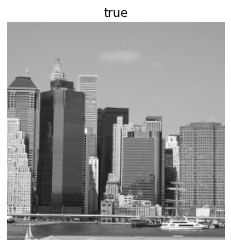

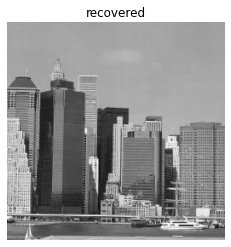

In [7]:
from solver_l1_norm import RecoveryL1NormNoisy

# Recovery - for low values of eta it is better to use SoS-L1Ball
wimrec_cpx, _ = RecoveryL1NormNoisy(0.01, yim, A, disp=True, method='SoS-L1Ball')
# The recovered coefficients could be complex!
imrec_cpx = A.getImageFromWavelet(wimrec_cpx)
imrec = np.abs(imrec_cpx)
# Compare true vs reconstructed image
print('Reconstruction error')
print('   Absolute ', la.norm((im - imrec_cpx).ravel()))
print('   Relative ', la.norm((im - imrec_cpx).ravel())/la.norm(im.ravel()))

plt.imshow(im, cmap='gray')
plt.title('true')
plt.axis('off')
plt.show()
plt.imshow(imrec, cmap='gray')
plt.title('recovered')
plt.axis('off')
plt.show()

### Noise

The measurements are usually corrupted by noise. In this case, we model it as additive Gaussian noise with variance ``sigma^2``. Usually the noise variance is determined by the **Signal-to-Noise Ratio (SNR)**. 


Number of complex measurements:  49103
Signal power:  15541.04307617356
Noise power:   309.95369950393234
SNR:           50.1398857346963


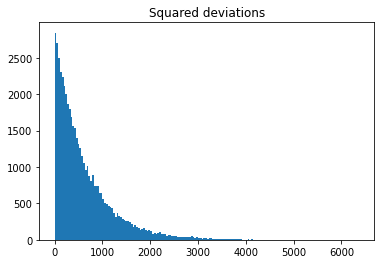

In [10]:
# Target SNR
SNR = 50
# Signal power. The factor 2 accounts for real/imaginary parts
yim_pow = la.norm(yim.ravel()) ** 2 / (2 * yim.size)
# Noise st. dev.
sigma = np.sqrt(yim_pow / SNR)
# Noisy measurements
y = yim + sigma * (np.random.normal(size=yim.shape) + 1j * np.random.normal(size=yim.shape))
z_pow = la.norm((y - yim).ravel()) ** 2 / (2 * yim.size)
print('Number of complex measurements: ', yim.size)
print('Signal power: ', yim_pow)
print('Noise power:  ', z_pow)
print('SNR:          ', yim_pow/z_pow)

_ = plt.hist(np.abs((y - yim).ravel()) ** 2, bins='auto') 
plt.title("Squared deviations")
plt.show()


### Noisy recovery

In this case we reconstruct the signal from noisy data. We use as parameter ``eta`` a factor ``sqrt(2 * m)``  times ``sigma``. **Warning:** This can take about 4min.


[RECOVERY: L1-NOISY]
 Method:          BPDN
 Bound:           5.5249E+03
 Initial values:
     t           [0.0000E+00,   3.7770E+04]
     f(t)        [-5.5249E+03, +3.3917E+04]
 01 | t* = 0.0000E+00 in [0.0000E+00, 3.7770E+04] | f: [-5.5249E+03, +3.3917E+04]
 02 | t* = 3.7770E+04 in [0.0000E+00, 3.7770E+04] | f: [-5.5249E+03, +3.3917E+04]
 03 | t* = 9.4687E+03 in [0.0000E+00, 3.7770E+04] | f: [-5.5249E+03, +1.6514E+04]
 04 | t* = 3.8290E+03 in [9.4687E+03, 3.7770E+04] | f: [+6.7823E+03, +1.6514E+04]
 05 | t* = 1.9145E+03 in [3.8290E+03, 9.4687E+03] | f: [+5.4707E+03, +6.7823E+03]
 06 | t* = 8.3882E+02 in [1.9145E+03, 3.8290E+03] | f: [+4.5038E+03, +5.4707E+03]
 07 | t* = 4.1941E+02 in [8.3882E+02, 1.9145E+03] | f: [+3.7544E+03, +4.5038E+03]
 08 | t* = 2.2854E+02 in [4.1941E+02, 8.3882E+02] | f: [+2.8567E+03, +3.7544E+03]
 09 | t* = 1.1427E+02 in [2.2854E+02, 4.1941E+02] | f: [+2.0672E+03, +2.8567E+03]
 10 | t* = 8.0459E+01 in [1.1427E+02, 2.2854E+02] | f: [+1.1893E+03, +2.0672E+03]
 1

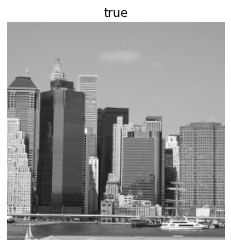

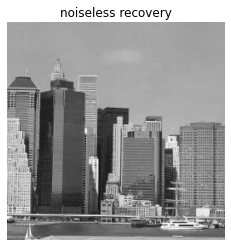

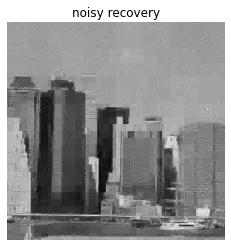

In [11]:
# Parameter eta
eta = np.sqrt(2 * y.size) * sigma
# Recovery
wimrec_noisy_cpx, _ = RecoveryL1NormNoisy(eta, y, A, disp=True, disp_method=False, method='BPDN')
# The recovered coefficients could be complex!
imrec_noisy_cpx = A.getImageFromWavelet(wimrec_noisy_cpx)
imrec_noisy = np.abs(imrec_noisy_cpx)
# Compare true vs reconstructed image
print('Reconstruction error')
print('   Absolute ', la.norm((im - imrec_noisy_cpx).ravel()))
print('   Relative ', la.norm((im - imrec_noisy_cpx).ravel())/la.norm(im.ravel()))
plt.imshow(im, cmap='gray')
plt.title('true')
plt.axis('off')
plt.show()
plt.imshow(imrec, cmap='gray')
plt.title('noiseless recovery')
plt.axis('off')
plt.show()
plt.imshow(imrec_noisy, cmap='gray')
plt.title('noisy recovery')
plt.axis('off')
plt.show()

### Debiasing

The reconstructed wavelet coefficients usually underestimate the true wavelet coefficients. To compensate for this effect, we debias the estimate. To do this, we restrict the operator to the support of the solution obtained for the noisy recovery.


[MinimizeSumOfSquares]
 Initial objective:   1.555637e+09
 0001 | obj: 7.500E+07 | gradNrm: 7.685E+04
 0053 | obj: 7.032E+07 | gradNrm: 1.544E-03
Reconstruction error - no debiasing
   Absolute  4229.184589958852
   Relative  0.10706240330927581
Reconstruction error - debiasing
   Absolute  7393.923297251889
   Relative  0.18717820923865947


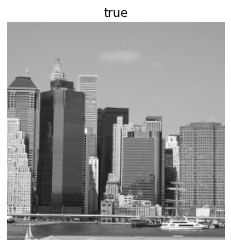

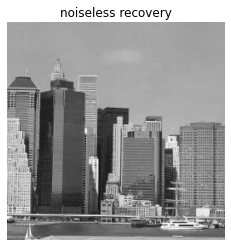

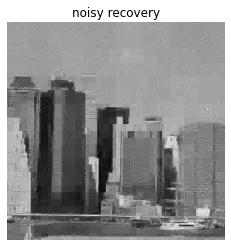

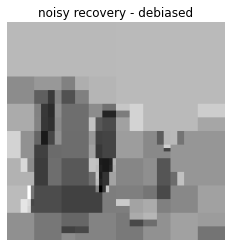

In [14]:

from solver_l1_norm import MinimizeSumOfSquares

# Support of noisy solution
wim_supp = np.where(np.abs(wimrec_noisy_cpx) > 1E-4 * la.norm(wimrec_noisy_cpx.ravel(), np.inf), True, False)
# Restriction of the operator
Adeb = A.colRestrict(wim_supp)
# Solve least-squares problem
wimrec_noisy_cpx_deb, _ = MinimizeSumOfSquares(y, Adeb, disp=True, printEvery=100)
# The recovered coefficients could be complex!
imrec_noisy_cpx_deb = Adeb.getImageFromWavelet(wimrec_noisy_cpx_deb)
imrec_noisy_deb = np.abs(imrec_noisy_cpx_deb)
# Compare true vs reconstructed image
print('Reconstruction error - no debiasing')
print('   Absolute ', la.norm((im - imrec_noisy_cpx).ravel()))
print('   Relative ', la.norm((im - imrec_noisy_cpx).ravel())/la.norm(im.ravel()))
print('Reconstruction error - debiasing')
print('   Absolute ', la.norm((im - imrec_noisy_cpx_deb).ravel()))
print('   Relative ', la.norm((im - imrec_noisy_cpx_deb).ravel())/la.norm(im.ravel()))
plt.imshow(im, cmap='gray')
plt.title('true')
plt.axis('off')
plt.show()
plt.imshow(imrec, cmap='gray')
plt.title('noiseless recovery')
plt.axis('off')
plt.show()
plt.imshow(imrec_noisy, cmap='gray')
plt.title('noisy recovery')
plt.axis('off')
plt.show()
plt.imshow(imrec_noisy_deb, cmap='gray')
plt.title('noisy recovery - debiased')
plt.axis('off')
plt.show()